# **M1 Exam Submission part 2**

## **Table of Contents**

#### I. Import Libraries and Data
#### II. Data Preparation
#### III. Model Development
#### IV. Model Evaluation

### Funding Duration Prediction:
### Target: funding_duration_days (Time to Secure Loan)

### Problem Statement:

The objective is to predict how long it will take for a loan request to be fully funded, based on factors such as the borrower's country, sector, activity type, loan amount, and number of lenders. By understanding these relationships, the model can provide insights into which factors lead to faster or slower funding times.
Type of Model:
The model will use regression, as the target variable (funding_duration_days) represents a continuous numerical value. The goal is to predict the number of days required to secure full funding for a loan based on the given features.
### Objective:
This model aims to assist lending platforms and financial institutions in forecasting how long a loan will take to be fully funded after a request is made. This can help in optimizing loan approval strategies, better managing borrower expectations, and allocating resources efficiently to improve funding success rates.

In [8]:
# install all requried libraries from requirement file (-r flag) and running in silent mode using -q flag
!pip install -q -r https://raw.githubusercontent.com/JAdamHub/M1-Exam-Submission/refs/heads/main/requirements.txt

In [9]:
#import libraries
import pandas as pd             # for data manipulation
import numpy as np              # for mathematical operations
import matplotlib.pyplot as plt # for plotting
import seaborn as sns           # for data visualization
from scipy.stats import zscore  # for standardizing data & removing outliers
import altair as alt            # for interactive visualization
from vega_datasets import data  # for data visualization

#additional libraries for importing data from github
import requests                 # used for importing data
import io                       # used for converting response content to a file-like object for pandas

# library used for gender mapping - section 4
import re

In [15]:
# definition of url-paths for datasets
# online
url1 = 'https://raw.githubusercontent.com/JAdamHub/M1-Exam-Submission/refs/heads/main/data/kiva_loans_part_0.csv'
url2 = 'https://raw.githubusercontent.com/JAdamHub/M1-Exam-Submission/refs/heads/main/data/kiva_loans_part_1.csv'
url3 = 'https://raw.githubusercontent.com/JAdamHub/M1-Exam-Submission/refs/heads/main/data/kiva_loans_part_2.csv'

# loading the urls into requests to download data
response1 = requests.get(url1)
response2 = requests.get(url2)
response3 = requests.get(url3)

# convert the response content to a file-like object for pandas using io.StringIO
# the advantage of StringIO is that it allows us to import the data without having to save it as a file for pandas
data_part1 = pd.read_csv(io.StringIO(response1.text))
data_part2 = pd.read_csv(io.StringIO(response2.text))
data_part3 = pd.read_csv(io.StringIO(response3.text))

# We can see, that the imported loan dataset consists of 3 parts. We will like to combine these to one dataset
data = pd.concat([data_part1, data_part2, data_part3])

### Data Preparation

In [13]:
# Dropping unnecessary columns
data = data.drop(['tags', 'use', 'currency', 'country_code', 'partner_id'], axis=1)

# we want to remove the missing rows from the dataset
# storing length of rows for comparing, >> before dropna.. <<
data_rows = len(data)

# dropping missing values
data.dropna(inplace=True)

# storing the now cleaned dataset
cleaned_rows = len(data)

# check..
drops = data_rows - cleaned_rows

# print the dropped rows and percentage of data removed
print(f"Number of dropped rows: {drops}")
print(f'In percentage {(drops / data_rows) * 100:.2f} % of the data was removed')
# check after cleaning
data.isna().sum()

KeyError: "['tags', 'use', 'currency', 'country_code', 'partner_id'] not found in axis"

### Filter countries to only include top 20 based on total loan_amount

In [7]:
# what is the total amount of loan_amount for each country?
country_loans = data.groupby('country')['loan_amount'].sum()

# we would like the top 20 countries
country_top_20 = country_loans.sort_values(ascending=False).head(20)

# using index we create a new variable with the top 20 countries
data = data[data['country'].isin(country_top_20.index)]

### Gender Mapping

In [8]:
### Gender Mapping (creating groups of male, female, and mixed gender groups)
# count the number of male and female borrowers by searching for occurrences of 'male' and 'female' in the 'borrower_genders' column
data['male_borrowers'] = data['borrower_genders'].apply(lambda x: len(re.findall(r'\bmale', x)))
data['female_borrowers'] = data['borrower_genders'].apply(lambda x: len(re.findall(r'\bfemale', x)))

# calculate the total number of borrowers by adding male and female borrower counts
data['borrowers_count'] = data['male_borrowers'] + data['female_borrowers']

# handle cases where 'borrowers_count' is 0 by replacing it with 1 to avoid division by zero
data['male_borrower_ratio'] = data['male_borrowers'] / data['borrowers_count'].replace(0, 1)

# function to classify the gender group based on the ratio of male borrowers
# if the ratio is 1, it means all borrowers are male, so return 'male(s)'
# if the ratio is 0, all borrowers are female, so return 'female(s)'
# otherwise, return 'mixed gender group' for groups with both male and female borrowers
def classify_genders(ratio):
    if ratio == 1:
        return 'male(s)'
    elif ratio == 0:
        return 'female(s)'
    else:
        return 'mixed gender group'

# apply the gender classification function to each row based on the 'male_borrower_ratio'
data['gender_class'] = data['male_borrower_ratio'].apply(classify_genders)

# print of the first 10 rows of new added columns to see the borrower genders, counts, ratios, and classifications
data[['borrower_genders', 'male_borrowers', 'female_borrowers', 'borrowers_count', 'male_borrower_ratio', 'gender_class']].head(10)

,borrower_genders,male_borrowers,female_borrowers,borrowers_count,male_borrower_ratio,gender_class
0,female,0,1,1,0.0,female(s)
1,"female, female",0,2,2,0.0,female(s)
3,female,0,1,1,0.0,female(s)
4,female,0,1,1,0.0,female(s)
7,female,0,1,1,0.0,female(s)
8,female,0,1,1,0.0,female(s)
9,female,0,1,1,0.0,female(s)
10,female,0,1,1,0.0,female(s)
11,female,0,1,1,0.0,female(s)
12,female,0,1,1,0.0,female(s)


In [9]:
### Removing outliers based on loan_amount
# calculate z-scores for loan_amount (our outlier detection)
z_scores = zscore(data['loan_amount'])

# get boolean array indicating the presence of outliers
# using 2 & -2 z_scores to get 95% of data within 2 standard deviations
data['outlier_loan_amount'] = (z_scores > 2) | (z_scores < -2)


#removing outliers
data_clean = data[~data['outlier_loan_amount']]

# check amount of outliers
data['outlier_loan_amount'].sum()

19416

In [10]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 435525 entries, 0 to 221186
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   435525 non-null  int64  
 1   funded_amount        435525 non-null  float64
 2   loan_amount          435525 non-null  float64
 3   activity             435525 non-null  object 
 4   sector               435525 non-null  object 
 5   country              435525 non-null  object 
 6   region               435525 non-null  object 
 7   posted_time          435525 non-null  object 
 8   disbursed_time       435525 non-null  object 
 9   funded_time          435525 non-null  object 
 10  term_in_months       435525 non-null  float64
 11  lender_count         435525 non-null  int64  
 12  borrower_genders     435525 non-null  object 
 13  repayment_interval   435525 non-null  object 
 14  date                 435525 non-null  object 
 15  male_borrowers       4

### Calculating funding duration (time between posted_time and funded_time)

In [11]:
loans = data_clean
# We would like to also include the time/duration between posted_time and funded_time - in other words: how long it takes to get a loan funded
# convert to pd.datetime
loans['posted_time'] = pd.to_datetime(loans['posted_time'])
loans['funded_time'] = pd.to_datetime(loans['funded_time'])

# calculate time between posted_time and funded_time
loans['funding_duration'] = loans['funded_time'] - loans['posted_time']

# the result in days instead
loans['funding_duration_days'] = (loans['funded_time'] - loans['posted_time']).dt.total_seconds() / (24 * 60 * 60)

# first rows to check
loans[['posted_time', 'funded_time', 'funding_duration', 'funding_duration_days']].head()

/var/folders/z7/j9rhznl118zbt_41ygz3rgyc0000gn/T/ipykernel_85690/3370879942.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans['posted_time'] = pd.to_datetime(loans['posted_time'])
/var/folders/z7/j9rhznl118zbt_41ygz3rgyc0000gn/T/ipykernel_85690/3370879942.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans['funded_time'] = pd.to_datetime(loans['funded_time'])
/var/folders/z7/j9rhznl118zbt_41ygz3rgyc0000gn/T/ipykernel_85690/3370879942.py:8: SettingWithCopyWarning: 
A value is trying to be set o

,posted_time,funded_time,funding_duration,funding_duration_days
0,2014-01-01 06:12:39+00:00,2014-01-02 10:06:32+00:00,1 days 03:53:53,1.162419
1,2014-01-01 06:51:08+00:00,2014-01-02 09:17:23+00:00,1 days 02:26:15,1.101562
3,2014-01-01 08:03:11+00:00,2014-01-01 13:00:00+00:00,0 days 04:56:49,0.206123
4,2014-01-01 11:53:19+00:00,2014-01-01 19:18:51+00:00,0 days 07:25:32,0.309398
7,2014-01-01 11:46:01+00:00,2014-01-10 18:18:44+00:00,9 days 06:32:43,9.272720


## SML Preparation

In [12]:
# Libs needed for section 7 (some already imported)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import r2_score
# Import the confusion matrix plotter module
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn for more styling options
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
#  Model selection & Regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from imblearn.under_sampling import RandomUnderSampler

# pipeline for the different models
from sklearn.pipeline import Pipeline

# decision Tree
from sklearn.tree import DecisionTreeRegressor

# tabular data explanation with LIME
import lime.lime_tabular  

# install shap & import
!pip install lime shap pdpbox -qqq

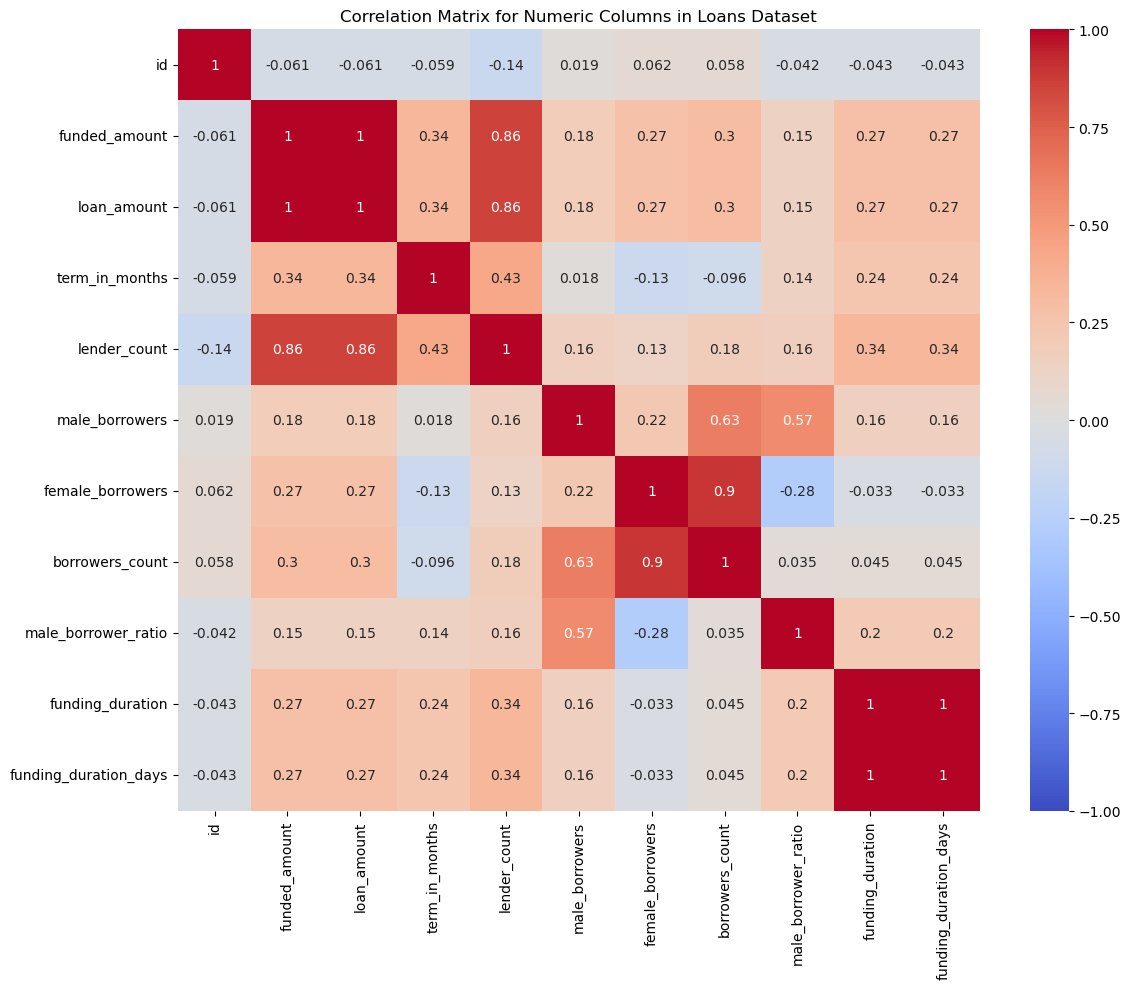

In [13]:
# it's a good idea to check the correlation matrix, to check if relevant columns may correlate to much with others
numeric_columns = loans.select_dtypes(include=[np.number]).columns

# Beregn korrelationsmatrix
corr_matrix = loans[numeric_columns].corr()

# Plot korrelationsmatrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix for Numeric Columns in Loans Dataset')
plt.tight_layout()
plt.show()

In [14]:
data_clean.head()

,id,funded_amount,loan_amount,activity,sector,country,region,posted_time,disbursed_time,funded_time,...,repayment_interval,date,male_borrowers,female_borrowers,borrowers_count,male_borrower_ratio,gender_class,outlier_loan_amount,funding_duration,funding_duration_days
0,653051,300.0,300.0,Fruits & Vegetables,Food,Pakistan,Lahore,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,...,irregular,2014-01-01,0,1,1,0.0,female(s),False,1 days 03:53:53,1.162419
1,653053,575.0,575.0,Rickshaw,Transportation,Pakistan,Lahore,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,...,irregular,2014-01-01,0,2,2,0.0,female(s),False,1 days 02:26:15,1.101562
3,653063,200.0,200.0,Embroidery,Arts,Pakistan,Lahore,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,...,irregular,2014-01-01,0,1,1,0.0,female(s),False,0 days 04:56:49,0.206123
4,653084,400.0,400.0,Milk Sales,Food,Pakistan,Abdul Hakeem,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,...,monthly,2014-01-01,0,1,1,0.0,female(s),False,0 days 07:25:32,0.309398
7,653078,400.0,400.0,Beauty Salon,Services,Pakistan,Ellahabad,2014-01-01 11:46:01+00:00,2013-12-20 08:00:00+00:00,2014-01-10 18:18:44+00:00,...,monthly,2014-01-01,0,1,1,0.0,female(s),False,9 days 06:32:43,9.272720


In [16]:
#Filtering only the relevant columns for the model
relevant_columns = [
    'loan_amount',
    'activity',
    'sector',
    'country',
    'region',
    'borrowers_count',
    'gender_class',
    'funding_duration_days',
    'term_in_months',
]


In [17]:
loans_df = loans[relevant_columns]

### Data Imbalance for country
Some countries account for more data than others, which could lead to imbalanced models.

In [18]:
print(loans_df['country'].value_counts().to_string())

country
Philippines                             157479
Kenya                                    61530
Cambodia                                 33254
Pakistan                                 24854
Peru                                     18362
Uganda                                   17787
Tajikistan                               17259
Colombia                                 17203
El Salvador                              16503
Ecuador                                  12496
Nicaragua                                 9677
Vietnam                                   8902
Palestine                                 6510
Armenia                                   6119
Paraguay                                  6114
Lebanon                                   5939
Guatemala                                 5536
Bolivia                                   5035
Mexico                                    3698
The Democratic Republic of the Congo      1268


In [19]:
# check initial distribution of countries
print("Country distribution:")
print(loans_df['country'].value_counts())

# Initialize RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=9000)

# Apply resampling using 'country' as a balancing feature
X_resampled, _ = rus.fit_resample(loans_df, loans_df['country'])

print("Country distribution after balancing:")
print(X_resampled['country'].value_counts())

# updating dataframe
loans_df = X_resampled

Country distribution:
country
Philippines                             157479
Kenya                                    61530
Cambodia                                 33254
Pakistan                                 24854
Peru                                     18362
Uganda                                   17787
Tajikistan                               17259
Colombia                                 17203
El Salvador                              16503
Ecuador                                  12496
Nicaragua                                 9677
Vietnam                                   8902
Palestine                                 6510
Armenia                                   6119
Paraguay                                  6114
Lebanon                                   5939
Guatemala                                 5536
Bolivia                                   5035
Mexico                                    3698
The Democratic Republic of the Congo      1268
Name: count, dtype: int64
Coun

In [20]:
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25360 entries, 187730 to 141827
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   loan_amount            25360 non-null  float64
 1   activity               25360 non-null  object 
 2   sector                 25360 non-null  object 
 3   country                25360 non-null  object 
 4   region                 25360 non-null  object 
 5   borrowers_count        25360 non-null  int64  
 6   gender_class           25360 non-null  object 
 7   funding_duration_days  25360 non-null  float64
 8   term_in_months         25360 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 1.9+ MB


In [21]:
#SAMPLING IS OPTIONAL
# loans_df = loans_df.sample(n=10000, random_state=9000)

### Setting up the target and feature variables + splitting data

In [22]:
# define the target variable 'y' (loan_amount)
y = loans_df['loan_amount']

# define the feature set 'X' (all other columns except loan_amount)
X = loans_df[['activity', 'sector', 'country', 'borrowers_count', 'funding_duration_days', 'region', 'gender_class', 'term_in_months']]

# preprocessing for numeric features
numeric_features = ['borrowers_count', 'funding_duration_days', 'term_in_months']
numeric_transformer = StandardScaler()

# preprocessing for categorical features
categorical_features = ['activity', 'sector', 'country', 'region', 'gender_class']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

### Creating pipelines

In [24]:
# Pipeline for Linear Regression
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Pipeline for Decision Tree Regression
pipeline_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor())
])

# Pipeline for Random Forest Regression
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])
 
# Pipeline for XGBoost
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor())
])

### Model Training without hyperparameterization

In [25]:
############################################################
# Train Linear Regression
pipeline_lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = pipeline_lr.predict(X_test)

# Evaluate
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Train & test score
train_score_lr = pipeline_lr.score(X_train, y_train)
test_score_lr = pipeline_lr.score(X_test, y_test)

print("Linear Regression Performance:")
print(f"  MSE: {mse_lr:.4f}")
print(f"  MAE: {mae_lr:.4f}")
print(f"  R²: {r2_lr:.4f}")
print(f"Train Score: {train_score_lr:.4f}")
print(f"Test Score: {test_score_lr:.4f}")

############################################################
# Train Random Forest Regression
pipeline_rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = pipeline_rf.predict(X_test)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Train & test score
train_score_rf = pipeline_rf.score(X_train, y_train)
test_score_rf = pipeline_rf.score(X_test, y_test)

print("\nRandom Forest Regression Performance:")
print(f"  MSE: {mse_rf:.4f}")
print(f"  MAE: {mae_rf:.4f}")
print(f"  R²: {r2_rf:.4f}")
print(f"Train Score: {train_score_rf:.4f}")
print(f"Test Score: {test_score_rf:.4f}")

############################################################
# Train XGBoost Regression
pipeline_xgb.fit(X_train, y_train)

# Make predictions
y_pred_rf = pipeline_xgb.predict(X_test)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Train & test score
train_score_rf = pipeline_xgb.score(X_train, y_train)
test_score_rf = pipeline_xgb.score(X_test, y_test)

print("\nXGBoost Performance:")
print(f"  MSE: {mse_rf:.4f}")
print(f"  MAE: {mae_rf:.4f}")
print(f"  R²: {r2_rf:.4f}")
print(f"Train Score: {train_score_rf:.4f}")
print(f"Test Score: {test_score_rf:.4f}")

############################################################

Linear Regression Performance:
  MSE: 144676.7655
  MAE: 276.0463
  R²: 0.5944
Train Score: 0.6961
Test Score: 0.5944

Random Forest Regression Performance:
  MSE: 119312.9638
  MAE: 243.1147
  R²: 0.6655
Train Score: 0.9537
Test Score: 0.6655

XGBoost Performance:
  MSE: 115411.3865
  MAE: 246.4512
  R²: 0.6765
Train Score: 0.7537
Test Score: 0.6765


### Hyperparamter tuning using cross-validation

#### Random Forest Hyperparameter tuning

In [26]:
# random forest tree - hyperparameter tuning with stronger overfitting reduction

import numpy as np

# expanded hyperparameter space with even stronger regularization to reduce overfitting
param_distributions = {
    'regressor__n_estimators': [50, 100, 150], 
    'regressor__max_depth': [10, 15, 20], 
    'regressor__min_samples_split': [5, 10, 15], 
    'regressor__min_samples_leaf': [3, 5, 7, 10]
}

# create the RandomizedSearchCV object with additional iterations and cv=5 for better generalization
random_search = RandomizedSearchCV(estimator=pipeline_rf, param_distributions=param_distributions,
                                   n_iter=15, cv=5, n_jobs=-1, scoring='r2', verbose=1, random_state=69)

# perform randomized search on the training data
random_search.fit(X_train, y_train)

# print the best hyperparameters and R^2 score
print(f"Best hyperparameters: {random_search.best_params_}")
print(f"Best cross-validation R^2 score: {random_search.best_score_}")

# check performance on the training and test sets
train_r2 = random_search.score(X_train, y_train)
test_r2 = random_search.score(X_test, y_test)
print(f"Random Forest - Training R^2 score: {train_r2}")
print(f"Random Forest - Test R^2 score: {test_r2}")


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best hyperparameters: {'regressor__n_estimators': 150, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 3, 'regressor__max_depth': 20}
Best cross-validation R^2 score: 0.6667048697399098
Random Forest - Training R^2 score: 0.816399066832645
Random Forest - Test R^2 score: 0.6692395523517867


In [27]:
# Pipeline for Random Forest Regression
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=150, 
                                        min_samples_split=5, 
                                        min_samples_leaf=3,
                                        max_depth=20))
])

### Cross Validation (Random Forest + XGBoost)

In [28]:
# RANDOM TREE FOREST
# perform 5-fold cross-validation
cv_scores = cross_val_score(pipeline_rf, X_train, y_train, cv=5, scoring='r2')

# train the model on the full training set
pipeline_rf.fit(X_train, y_train)

# evaluate the model on training and test data
train_score_rf = pipeline_rf.score(X_train, y_train)
test_score_rf = pipeline_rf.score(X_test, y_test)

# calculate MSE and RMSE
y_pred_rf = pipeline_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

# print cross-validation scores and the final evaluation
print(f"Random Forest")
print(f"Cross-Validation R^2 Scores: {cv_scores}")
print(f"Mean Cross-Validation R^2: {cv_scores.mean()}")
print(f'Random Forest - Training R^2 score: {train_score_rf}')
print(f'Random Forest - Test R^2 score: {test_score_rf}')
print(f'Random Forest - Test MSE: {mse_rf}')
print(f'Random Forest - Test RMSE: {rmse_rf}')

####################################################################################
# XGBoost

# Perform 5-fold cross-validation
cv_scores = cross_val_score(pipeline_xgb, X_train, y_train, cv=5, scoring='r2')

# Train the model on the full training set
pipeline_xgb.fit(X_train, y_train)

# Evaluate the model on training and test data
train_score_rf = pipeline_xgb.score(X_train, y_train)
test_score_rf = pipeline_xgb.score(X_test, y_test)

# Calculate MSE and RMSE
y_pred_rf = pipeline_xgb.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

# Print cross-validation scores and the final evaluation
print(f"XGBoost")
print(f"Cross-Validation R^2 Scores: {cv_scores}")
print(f"Mean Cross-Validation R^2: {cv_scores.mean()}")
print(f'XGBoost - Training R^2 score: {train_score_rf}')
print(f'XGBoost - Test R^2 score: {test_score_rf}')
print(f'XGBoost - Test MSE: {mse_rf}')
print(f'XGBoost - Test RMSE: {rmse_rf}')

Random Forest
Cross-Validation R^2 Scores: [0.65429237 0.66227356 0.66844467 0.68298512 0.66713244]
Mean Cross-Validation R^2: 0.6670256319297613
Random Forest - Training R^2 score: 0.8166375738217238
Random Forest - Test R^2 score: 0.668131499281341
Random Forest - Test MSE: 118380.0147473903
Random Forest - Test RMSE: 344.0639689758146
XGBoost
Cross-Validation R^2 Scores: [0.65799588 0.66977756 0.67492493 0.69015379 0.67311046]
Mean Cross-Validation R^2: 0.6731925230998568
XGBoost - Training R^2 score: 0.7536581221122882
XGBoost - Test R^2 score: 0.6764538011618235
XGBoost - Test MSE: 115411.38645874488
XGBoost - Test RMSE: 339.7225139120822


In [29]:

# create a votingregressor that combines the two pipeline models
ensemble_model = VotingRegressor(
    estimators=[('rf', pipeline_rf), ('xgb', pipeline_xgb)],
    weights=[0.3, 0.7]  # 30% Random Forest & 70% XGBoost 
    # ^^^ possible to adjust weights based on model performance
)

# fit the ensemble model
ensemble_model.fit(X_train, y_train)

# evaluate the ensemble model on training data
ensemble_train_score = ensemble_model.score(X_train, y_train)
print(f"Ensemble Model Training R2 Score: {ensemble_train_score:.4f}")

# evaluate the ensemble model on test data
ensemble_test_score = ensemble_model.score(X_test, y_test)
print(f"Ensemble Model Test R2 Score: {ensemble_test_score:.4f}")

# compare with individual models
# random forest
pipeline_rf.fit(X_train, y_train)
rf_train_score = pipeline_rf.score(X_train, y_train)
rf_test_score = pipeline_rf.score(X_test, y_test)
print(f"Random Forest Pipeline Training R2 Score: {rf_train_score:.4f}")
print(f"Random Forest Pipeline Test R2 Score: {rf_test_score:.4f}")

# xgboost
pipeline_xgb.fit(X_train, y_train)
xgb_train_score = pipeline_xgb.score(X_train, y_train)
xgb_test_score = pipeline_xgb.score(X_test, y_test)
print(f"XGBoost Pipeline Training R2 Score: {xgb_train_score:.4f}")
print(f"XGBoost Pipeline Test R2 Score: {xgb_test_score:.4f}")

# make predictions with the ensemble model
y_pred = ensemble_model.predict(X_test)

Ensemble Model Training R2 Score: 0.7807
Ensemble Model Test R2 Score: 0.6823
Random Forest Pipeline Training R2 Score: 0.8162
Random Forest Pipeline Test R2 Score: 0.6683
XGBoost Pipeline Training R2 Score: 0.7537
XGBoost Pipeline Test R2 Score: 0.6765


### Visulization of Ensemble Model

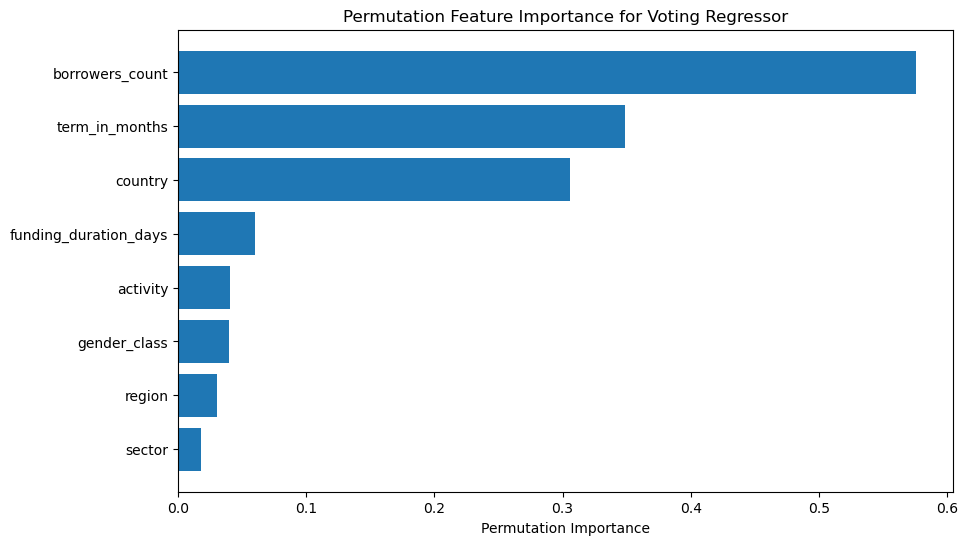

In [30]:


# fit your VotingRegressor model
ensemble_model.fit(X_train, y_train)

# calculate permutation feature importance on the test set
result = permutation_importance(ensemble_model, X_test, y_test, n_repeats=10, random_state=69, n_jobs=-1)

# plot the feature importance
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), X_test.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Permutation Feature Importance for Voting Regressor")
plt.show()


/var/folders/z7/j9rhznl118zbt_41ygz3rgyc0000gn/T/ipykernel_85690/1372295358.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Ideal Fit')


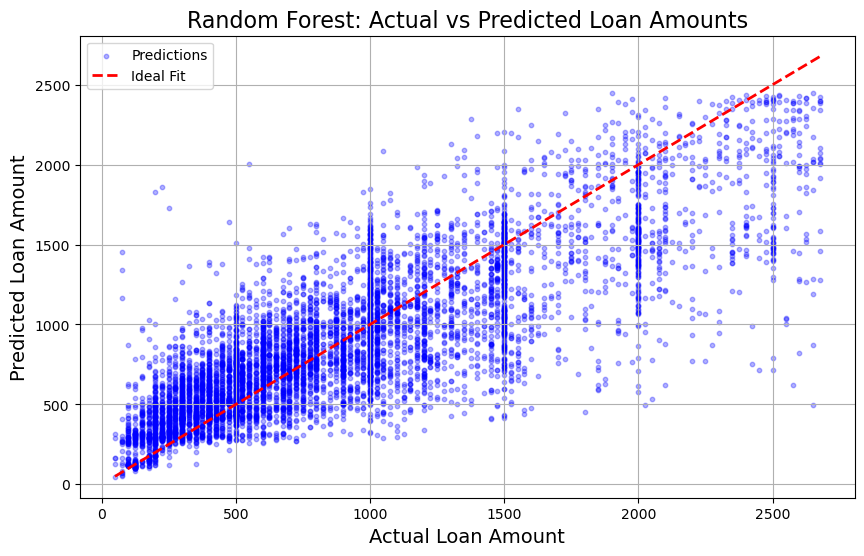

In [31]:

# Step 1: Make predictions on the test set using your Ensemble model
y_pred = ensemble_model.predict(X_test)

# Step 2: Plot actual vs predicted values with transparency and reduced marker size
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, s=10, color='blue', label='Predictions')  # Reduced marker size (s=10), transparency (alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Ideal Fit')

plt.title('Ensemble Model: Actual vs Predicted Loan Amounts', fontsize=16)
plt.xlabel('Actual Loan Amount', fontsize=14)
plt.ylabel('Predicted Loan Amount', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


### Exporting ensemble model to joblib format for usage in Streamlit


In [32]:
import joblib
joblib.dump(ensemble_model, 'ensemble_model.joblib')

['ensemble_model.joblib']

### Export target X_test (loan_amount) & y_test (features) to csv to be used in Streamlit deployment visualization 

In [7]:
X_test.to_csv('data/X_test.csv', index=False)
y_test.to_csv('data/y_test.csv', index=False)

NameError: name 'X_test' is not defined